In [2]:
import pandas as pd
import numpy as np
import os

## Description of Initial Synthetic Income Data Generation

This section of code is used to generate preliminary synthetic income distribution samples based on the original data. The workflow is as follows:

1. **Data Reading and Preprocessing**  
    - Read the original data file (e.g., `Business size_gender.csv`) from the specified path.
    - Filter out rows with missing key fields (`feature`, `number_of_jobs`, `median_income`).
    - Keep only data where gender is "Males" or "Females", and reset the index.
    - Round the `number_of_jobs` column and convert it to integer type.

2. **Synthetic Sample Generation**  
    - Use the `generate_initial_data` function to generate income samples for each row, based on `median_income` and `number_of_jobs`, with added normal distribution noise.
    - Each sample retains only the `gender` and `median_income` fields.

3. **Result**  
    - Obtain a new DataFrame (`new_df`) containing the preliminary synthetic income distribution data, which can be used for subsequent feature assignment and analysis.

The purpose of this step is to generate more granular synthetic samples based on the original statistical data, laying the foundation for further feature filling and simulation analysis.

In [ ]:
def generate_initial_data(df, noise_percent=10):
    """
    For each row, generate samples equal to number_of_jobs, each sample's income is median_income plus normal noise.
    Returns a new DataFrame with N samples per row, keeping only gender and median_income.
    """
    income_col = 'median_income'
    jobs_col = 'number_of_jobs'
    records = []
    for _, row in df.iterrows():
        n = int(row[jobs_col])
        mu = row[income_col]
        gender = row['gender']
        incomes = np.random.normal(loc=mu, scale=noise_percent/100 * mu, size=n)
        for income in incomes:
            records.append({'gender': gender, income_col: income})
    return pd.DataFrame(records)

# example usage
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
# df = df[df['gender'].isin(['Males', 'Females'])].reset_index(drop=True) # Case sensitive for some of the pre transformed files
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True) # Case for industry and age files
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)

# print(new_df.head(20))
# print(df.head(20))

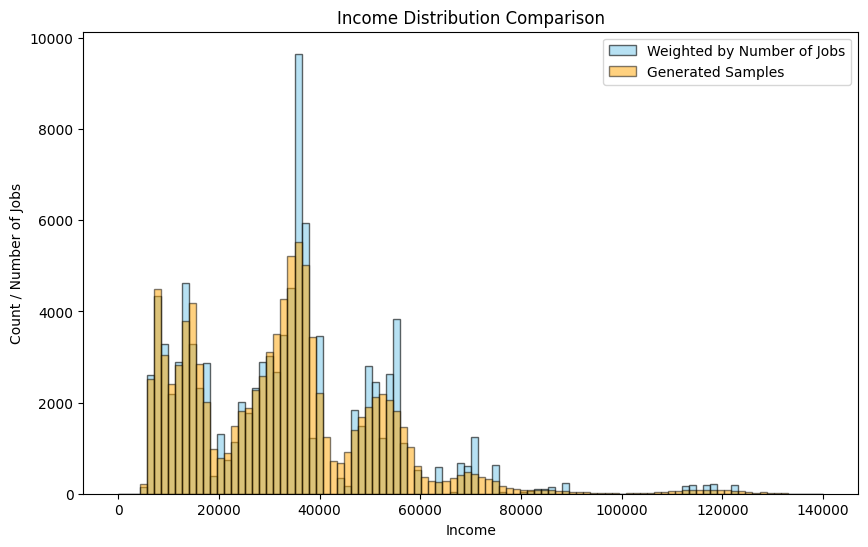

In [4]:
import matplotlib.pyplot as plt
bins = np.linspace(0, 140000, 101)
plt.figure(figsize=(10, 6))
plt.hist(df['median_income'], bins=bins, weights=df['number_of_jobs'], color='skyblue', edgecolor='black', alpha=0.6, label='Weighted by Number of Jobs')
plt.hist(new_df['median_income'], bins=bins, color='orange', edgecolor='black', alpha=0.5, label='Generated Samples')
plt.xlabel('Income')
plt.ylabel('Count / Number of Jobs')
plt.title('Income Distribution Comparison')
plt.legend()
plt.show()

## Independent Marginal Sampling Code Documentation

This code implements the independent marginal sampling workflow, which includes the following steps:

1. **Original Data Reading and Preprocessing**  
    - Read the original data file (e.g., `Industry_gender.csv`).
    - Filter valid data, handle missing values, and convert data types.

2. **Initial Synthetic Sample Generation**  
    - For each row, generate income samples based on `median_income` and `number_of_jobs`, with added normal distribution noise to introduce randomness.
    - The generated samples retain only the `gender` and `median_income` fields.

3. **Feature Marginal Distribution Statistics**  
    - For each feature, calculate its marginal probability distribution and weighted mean (e.g., mean income).

4. **Feature Assignment**  
    - Independently assign feature categories to each synthetic sample according to the marginal probability of each feature.
    - Optionally optimize assignment based on the distance to the target mean.

5. **Result Saving**  
    - The final synthetic data can be used for further analysis or modeling.

In [ ]:
def get_feature_stats(df, feature_name, group_col='feature'):
    """
    Calculate the probability distribution and weighted mean income for a given feature.
    """
    weight_col='number_of_jobs'
    income_col='median_income'
    df = df.dropna(subset=[group_col, weight_col, income_col])
    prob = df.groupby(group_col)[weight_col].sum()
    prob = prob / prob.sum()
    # Weighted mean income
    def weighted_mean(x):
        return (x[weight_col] * x[income_col]).sum() / x[weight_col].sum()
    mean_income = df.groupby(group_col).apply(weighted_mean)
    stats = pd.DataFrame({
        'prob': prob,
        'mean_income': mean_income
    })
    return stats

def process_feature_file(folder, fname, show_stats=False):
    """
    Process a single feature file and return statistical results.
    """
    feature_name = fname[:-11]
    if feature_name in ['Employment size', 'Job duration', 'Type of legal organisation']:
        return None
    fpath = os.path.join(folder, fname)
    df = pd.read_csv(fpath)
    df = df.rename(columns={'feature': feature_name})
    stats = get_feature_stats(df, feature_name=feature_name, group_col=feature_name)
    if show_stats:
        print(f"==== {feature_name} ====")
        print(stats)
        print()
    return stats

## `fill_features` Class Documentation

The `fill_features` class is used to independently assign feature categories to synthetic samples according to the marginal distribution probabilities and target means of each feature. Its main functions and parameters are as follows:

### Initialization Parameters

- `new_df`: DataFrame of synthetic samples, must contain columns for the features to be assigned.
- `feature_dist`: Feature distribution statistics (including category probabilities and means).
- `feature_col`: Name of the feature column to be filled.
- `threshold`: Stopping threshold for filling (default 1000), deprecated.
- `fill_propotion`: Filling proportion, determines the number of samples assigned to each category (default 0.9).
- `samples_per_round`: Proportion of samples assigned per round (default 0.01).
- `test_mode`: Test mode, controls the number of filling rounds (0=normal, 1=2 rounds, 2=20 rounds).

### Main Methods

- `init_distance_table()`: Initializes the distance table, calculating the absolute distance between each sample and the target mean of each category, used for optimized assignment.
- `fill()`: Main filling process, iteratively assigns samples to each category until the target number is reached or test conditions are met.
- `fill_one_round()`: Performs one round of filling, assigning samples to each category based on minimum distance.
- `sd_check()`: Checks the difference between the mean of assigned samples and the target mean for each category.
- `filled_finish_check()`: Checks whether all categories have reached the target number of assignments.
- `get_fill_index()`: Returns the indices of samples assigned to each category.
- `get_result_df()`: Returns the filled DataFrame.

### Workflow

1. Initialize the distance table, calculating the distance between each sample and the target mean of each category.
2. Assign samples to each category according to category probability and target mean, prioritizing samples with smaller distances.
3. Iterate the assignment until all categories reach the target number or test conditions are met.
4. At any time, check the difference between the assigned mean and the target mean to optimize the assignment.

This class is suitable for feature assignment tasks under the independent marginal distribution assumption, supporting efficient filling and mean control for large-scale synthetic data.

In [22]:
class fill_features:
    def __init__(self, new_df, feature_dist, feature_col, threshold=1000, fill_propotion=0.9, samples_per_round=0.01, test_mode=0):
        self.new_df = new_df
        self.feature_dist = feature_dist
        self.feature_col = feature_col
        self.threshold = threshold
        self.target_num_samples = round(feature_dist['prob'] * new_df.shape[0] * fill_propotion).astype(int)
        self.current_num_samples = pd.Series(0, index=feature_dist.index)
        self.samples_marks = {class_name: [] for class_name in feature_dist.index}
        self.samples_per_round = np.ceil(self.target_num_samples * samples_per_round).astype(int)
        self.rest_samples = new_df.index.tolist()
        self.all_filled = False
        self.diff = {class_name: 0 for class_name in feature_dist.index}
        self.test_mode = test_mode
        self.init_distance_table()

    def init_distance_table(self):
        print("Initializing distance table...")
        self.distance_table = pd.DataFrame(index=self.new_df.index, columns=self.feature_dist.index)
        for class_name in self.feature_dist.index:
            target_mean = self.feature_dist.loc[class_name, 'mean_income']
            self.distance_table[class_name] = (self.new_df['median_income'] - target_mean).abs()
        self.distance_table = self.distance_table.fillna(np.inf)
        print("Distance table initialized.")

    def fill(self):
        round = 0
        while not self.all_filled:
            if self.test_mode == 1 and round >= 2:
                break
            elif self.test_mode == 2 and round >= 20:
                break
            if round % 50 == 0:
                print(f"--- Round {round} ---")
                self.sd_check()
            self.fill_one_round()
            round += 1
            self.filled_finish_check()
        print(f"Filling completed in {round} rounds.")
        print("The final differences:")
        self.sd_check()

    def fill_one_round(self):
        current_to_fill = self.target_num_samples - self.current_num_samples
        for class_name, to_fill in current_to_fill.items():
            if to_fill > 0:
                n_fill = min(self.samples_per_round[class_name], to_fill)
                candidates_idx = self.rest_samples
                candidates_dist = self.distance_table.loc[candidates_idx, class_name]
                select_index = candidates_dist.nsmallest(n_fill).index.tolist()
                
                self.new_df.loc[select_index, self.feature_col] = class_name
                self.current_num_samples[class_name] += n_fill
                self.samples_marks[class_name].extend(select_index)
                self.rest_samples = [idx for idx in self.rest_samples if idx not in select_index]


    def sd_check(self):
        print("Difference from target mean income:")
        for class_name in self.feature_dist.index:
            target_mean = self.feature_dist.loc[class_name, 'mean_income']
            idxs = self.samples_marks[class_name]
            if idxs:
                current_mean = self.new_df.loc[idxs, 'median_income'].mean()
                self.diff[class_name] = target_mean - current_mean
                print(f"  {class_name}: {self.diff[class_name]}")
            else:
                print(f"  {class_name}: No samples assigned")
        print()

    def filled_finish_check(self):
        self.all_filled = all(self.current_num_samples >= self.target_num_samples)

    def get_fill_index(self):
        return self.samples_marks

    def get_result_df(self):
        return self.new_df

In [ ]:
# Base test on feature filling
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True)
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)
for col in ['Age', 'Arrival_group', 'Business_size', 'Industry', 'Institutional_sector', 'Job_duration', 'Visa_group']:
    new_df[col] = ""
    
folder = r"E:\git\DataScience_Project_Team_25\data\pre_transform"
feature_dist = process_feature_file(folder, 'Age group_gender.csv')
fill_age = fill_features(new_df, feature_dist, 'Age', threshold=1000, test_mode=0)
fill_age.fill()

Initializing distance table...
Distance table initialized.
--- Round 0 ---
Difference from target mean income:
  14 years and under: No samples assigned
  15 to 17 years: No samples assigned
  18 to 20 years: No samples assigned
  21 to 24 years: No samples assigned
  25 to 29 years: No samples assigned
  30 to 34 years: No samples assigned
  35 to 39 years: No samples assigned
  40 to 44 years: No samples assigned
  45 to 49 years: No samples assigned
  50 to 54 years: No samples assigned
  55 to 59 years: No samples assigned
  60 to 64 years: No samples assigned
  65 to 69 years: No samples assigned
  70 to 74 years: No samples assigned
  75 to 79 years: No samples assigned
  80 to 84 years: No samples assigned
  85 years and over: No samples assigned

--- Round 50 ---
Difference from target mean income:
  14 years and under: -4225.39152457545
  15 to 17 years: -2881.8065911609297
  18 to 20 years: -1.711046535542664
  21 to 24 years: -1.5375115172973892
  25 to 29 years: 4.186869597

In [24]:
# Test with full fill
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True)
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)
for col in ['Age', 'Arrival_group', 'Business_size', 'Industry', 'Institutional_sector', 'Job_duration', 'Visa_group']:
    new_df[col] = ""
    
folder = r"E:\git\DataScience_Project_Team_25\data\pre_transform"
feature_dist = process_feature_file(folder, 'Age group_gender.csv')
fill_age = fill_features(new_df, feature_dist, 'Age', threshold=1000, test_mode=0, fill_propotion=1, samples_per_round=0.005)
fill_age.fill()

Initializing distance table...
Distance table initialized.
--- Round 0 ---
Difference from target mean income:
  14 years and under: No samples assigned
  15 to 17 years: No samples assigned
  18 to 20 years: No samples assigned
  21 to 24 years: No samples assigned
  25 to 29 years: No samples assigned
  30 to 34 years: No samples assigned
  35 to 39 years: No samples assigned
  40 to 44 years: No samples assigned
  45 to 49 years: No samples assigned
  50 to 54 years: No samples assigned
  55 to 59 years: No samples assigned
  60 to 64 years: No samples assigned
  65 to 69 years: No samples assigned
  70 to 74 years: No samples assigned
  75 to 79 years: No samples assigned
  80 to 84 years: No samples assigned
  85 years and over: No samples assigned

--- Round 50 ---
Difference from target mean income:
  14 years and under: -4476.37771102568
  15 to 17 years: -2798.395791550153
  18 to 20 years: -4.454566879285267
  21 to 24 years: -31.704560779498934
  25 to 29 years: -282.2407611

In [ ]:
# Full filling every feature
fpath = r"E:\git\DataScience_Project_Team_25\data\pre_transform\Industry_gender.csv"
df = pd.read_csv(fpath).dropna(subset=['feature', 'number_of_jobs', 'median_income'])
df = df[df['gender'].isin(['MALES', 'FEMALES'])].reset_index(drop=True)
df['number_of_jobs'] = df['number_of_jobs'].round().astype(int)
new_df = generate_initial_data(df, noise_percent=5)
feature_names = ['Age', 'Arrival_group', 'Business_size', 'Industry', 'Institutional_sector', 'Job_duration', 'Visa_group']
for col in feature_names:
    new_df[col] = ""

feature_files = [
    'Age group_gender.csv',
    'Arrival Group_gender.csv',
    'Business size_gender.csv',
    'Industry_gender.csv',
    'Institutional sector_gender.csv',
    'Job duration from T20_gender.csv',
    'Visa group_gender.csv'
]

for feature_name, fname in zip(feature_names, feature_files):
    feature_dist = process_feature_file(folder, fname)
    print("Assigning feature:", feature_name)
    fill_feature = fill_features(new_df, feature_dist, feature_name, threshold=1000, test_mode=0, fill_propotion=1, samples_per_round=0.005)
    fill_feature.fill() #update new_df


Assigning feature: Age
Initializing distance table...
Distance table initialized.
--- Round 0 ---
Difference from target mean income:
  14 years and under: No samples assigned
  15 to 17 years: No samples assigned
  18 to 20 years: No samples assigned
  21 to 24 years: No samples assigned
  25 to 29 years: No samples assigned
  30 to 34 years: No samples assigned
  35 to 39 years: No samples assigned
  40 to 44 years: No samples assigned
  45 to 49 years: No samples assigned
  50 to 54 years: No samples assigned
  55 to 59 years: No samples assigned
  60 to 64 years: No samples assigned
  65 to 69 years: No samples assigned
  70 to 74 years: No samples assigned
  75 to 79 years: No samples assigned
  80 to 84 years: No samples assigned
  85 years and over: No samples assigned

--- Round 50 ---
Difference from target mean income:
  14 years and under: -4478.290449250441
  15 to 17 years: -2798.8123840436506
  18 to 20 years: -20.869569226174463
  21 to 24 years: -27.22322016274302
  25 

In [30]:
new_df.to_csv(r"E:\git\DataScience_Project_Team_25\data\synthetic\assuming_independent_initial_synthetic.csv", index=False)